## Решающие деревья ##

### О задании

В процессе мы:

1. Поиспользуем решающие деревья из `sklearn` для задачи классификации на простых двумерных датасетах, провизуализируем разделяющие плоскости и посмотрим есть ли переобучение.

2. Реализуем своё решающее дерево для задачи классификации и сравним его со стандартной имплементацией.

3. Исследуем влияние бэггинга на смещение и разброс.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from code5 import DecisionTree, find_best_split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

## Решающие деревья

### Визуализация 

Рассмотрим три простых двумерных датасета, сгенерированных с помощью `make_moons`, `make_circles` и `make_classification`.

In [7]:
from sklearn.datasets import make_moons, make_circles, make_classification

datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2,
                        class_sep=0.75, random_state=3, n_redundant=0)
]

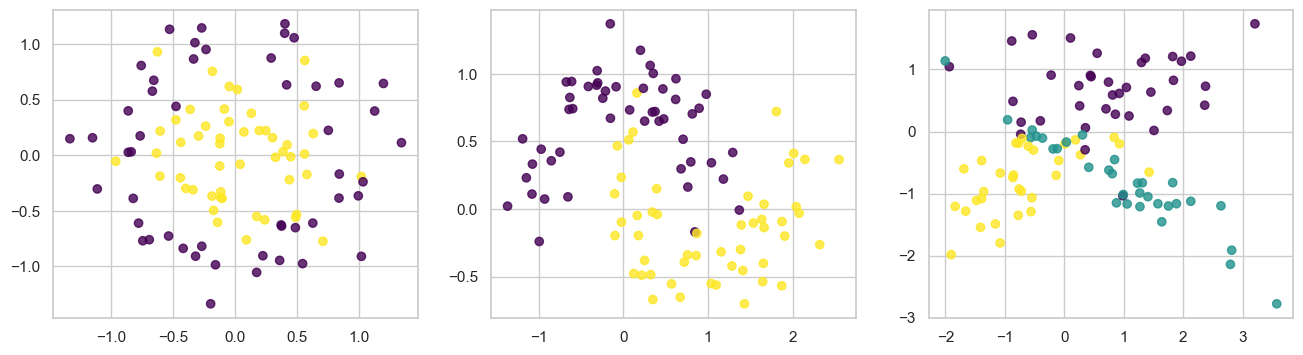

In [8]:
plt.figure(figsize=(16, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap="viridis", alpha=0.8)

__1.__

Для каждого датасета обучим решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Построим разделящие поверхности и посчитаем accuracy на обучающей и тестовой выборках. 

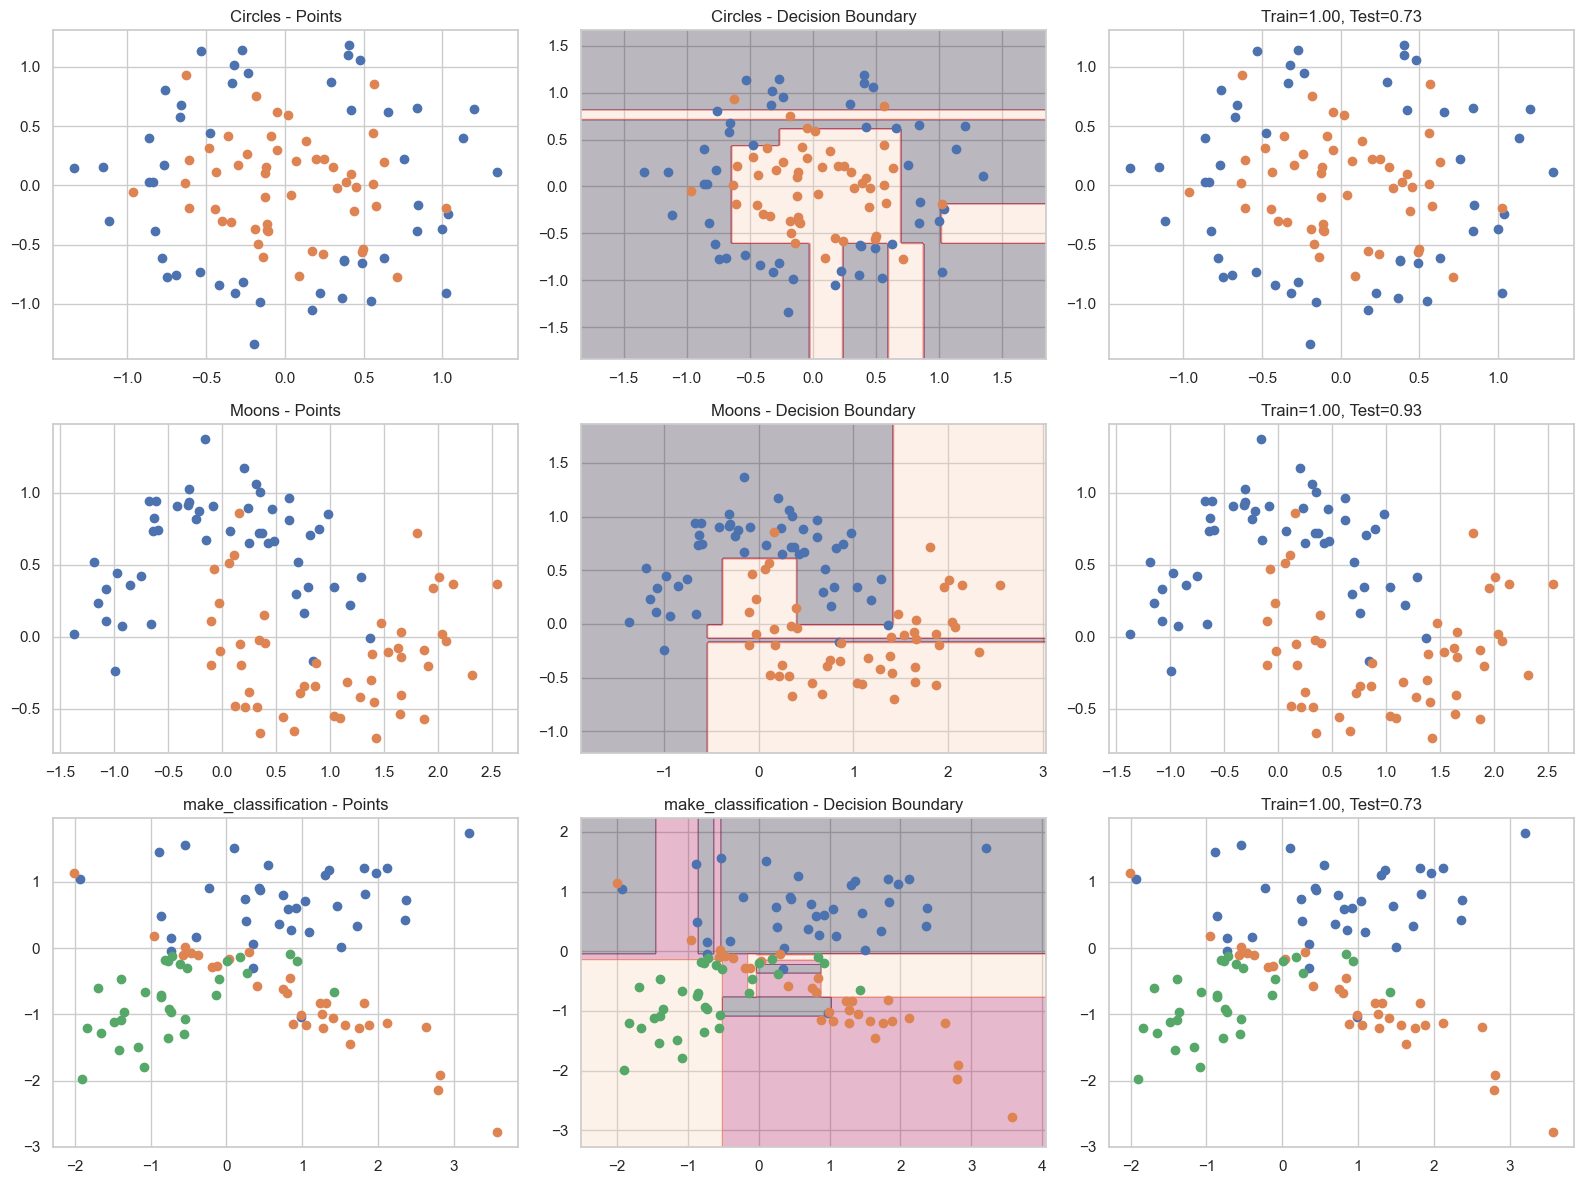

Circles    | train = 1.000, test = 0.733
Moons      | train = 1.000, test = 0.933
make_classification | train = 1.000, test = 0.733


In [13]:
names = ["Circles", "Moons", "make_classification"]

plt.figure(figsize=(16, 12))
results = []

for idx, ((X, y), name) in enumerate(zip(datasets, names)):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0
    )

    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    results.append((name, train_acc, test_acc))

    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot(3, 3, 3*idx + 1)
    plt.title(f"{name} - Points")
    for c in np.unique(y):
        plt.scatter(X[y == c, 0], X[y == c, 1])
        
    plt.subplot(3, 3, 3*idx + 2)
    plt.title(f"{name} - Decision Boundary")
    plt.contourf(xx, yy, Z, alpha=0.3)
    for c in np.unique(y):
        plt.scatter(X[y == c, 0], X[y == c, 1])

    plt.subplot(3, 3, 3*idx + 3)
    plt.title(f"Train={train_acc:.2f}, Test={test_acc:.2f}")
    for c in np.unique(y):
        plt.scatter(X[y == c, 0], X[y == c, 1])

plt.tight_layout()
plt.show()

for name, tr, ts in results:
    print(f"{name:10s} | train = {tr:.3f}, test = {ts:.3f}")

Модель переобучается на make_circles и слегка переобучается на make_moons, потому что, во-первых, она запоминает шум, поданный как гиперпараметр, а во-вторых, из-за слишком глубокого дерева. 

В то время как переобучение на make_classification происходит из-за частичного перекрытия классов (class_sep=0.75), ведь на тесте мы попадаем как раз в эти области, а неограниченная глубина дерева усиливает эффект. 

__2.__

Возьмем make_moons из предыдущего задания и исследуем на его примере влияние на итоговое качество двух гиперпараметров одновременно. Для каждой пары значений посчитаем accuracy на обучающей и тестовой выборках и сохраним результаты в таблицу.

Визуализируем зависимость качества на тестовой выборке от значений выбранных гиперпараметров. Посмотрим при каких значениях наблюдается лучшее соотношение разброса и смещения.

In [17]:
X, y = make_moons(noise=0.2, random_state=888)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

max_depth_values = [1, 2, 3, 4, 5, 7, 10, None]
min_leaf_values = [1, 2, 3, 5, 8, 12]

results = []

for depth in max_depth_values:
    for leaf in min_leaf_values:
        clf = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_leaf=leaf,
            random_state=0
        )
        clf.fit(X_train, y_train)

        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)

        results.append({
            "max_depth": depth,
            "min_samples_leaf": leaf,
            "train_acc": train_acc,
            "test_acc": test_acc
        })

df = pd.DataFrame(results)
df.head(20)

,max_depth,min_samples_leaf,train_acc,test_acc
0,1.0,1,0.828571,0.966667
1,1.0,2,0.828571,0.966667
2,1.0,3,0.828571,0.966667
3,1.0,5,0.828571,0.966667
4,1.0,8,0.828571,0.966667
5,1.0,12,0.828571,0.966667
6,2.0,1,0.914286,1.000000
7,2.0,2,0.914286,1.000000
8,2.0,3,0.900000,1.000000
9,2.0,5,0.871429,0.933333


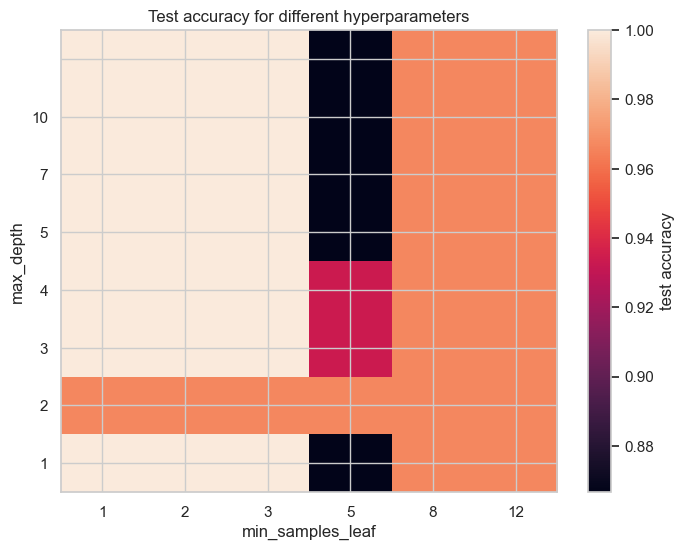

In [19]:
yatadjik = df.pivot(index="max_depth", columns="min_samples_leaf", values="test_acc")

plt.figure(figsize=(8, 6))
plt.title("Test accuracy for different hyperparameters")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.imshow(yatadjik, aspect="auto", origin="lower")
plt.colorbar(label="test accuracy")

plt.xticks(range(len(min_leaf_values)), min_leaf_values)
plt.yticks(range(len(max_depth_values)), max_depth_values)

plt.show()

Лучшее соотношение разброса и смещения наблюдается при max_depth = 1, 2, 3, 4, 5, 7, 10 и min_samples_leaf = 1, 2 , 3.
То есть, небольшая глубина и маленькое минимальное количество объектов в листе позволяют дереву очень хорошо обучится и выбить test_acc = 1 и высокое train_acc - поэтому именно при таких значениях будет лучшее соотношение разброса и смещения.

### Решающие деревья своими руками

__3.__

Реализуем функцию `find_best_split` из модуля `code5.py`, её сигнатура прописана в соответствующем файле.

Под критерием Джини подразумевается следующая функция качества разбиения:

$$
Q(R) = -\frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r),
$$

где $R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево соответственно.

Функция неоднородности (критерий Джини) для множества $R$ определяется как

$$
H(R) = 1 - \sum_{k=1}^{K} p_k^2,
$$

где $p_k$ - доля объектов класса $k$ в множестве $R$, а $K$ - число различных классов в текущем узле.

Замечание: при $K=2$ формула сводится к бинарному случаю $H(R)=1-p_0^2-p_1^2$, где $p_1$ и $p_0$ $-$ доля объектов классов $1$ и $0$ соответственно.

__4.__

Загрузим датасет [Student Performance](https://archive.ics.uci.edu/dataset/320/student+performance). Далее поработаем с данными и создадим бинарный признак `pass`, который будет равен единице, если итоговая оценка `G3` не меньше $10$, и нулю в противном случае. Затем выберем пять числовых признаков, среди которых должны быть как очень информативные, так и потенциально неинформативные. 

Для каждого из выбранных признаков построим график зависимости критерия Джини от возможного порога разделения. Отобразим все пять кривых на одном рисунке.

Для каждого из выбранных признаков дополнительно визуализируем зависимость
"значение признака - класс (0/1)".


G1, G2 - помогают прогнозировать g3, являются очень информативными, ведь прямым образом связаны с финальной оценкой.

absences - количество пропусков, скорее всего, является слабым признаком, ведь среднее по нему значение равно 5.7 - ииными словами, вряд ли 5 пропусков могут сильно повлиять на оценку.

studytime - средне-информативный, поскольку явно влияет на итоговую оценку, но большое количество часов за учебой не всегда приводит к отличной итоговой оценке.

failures - потенциально сильно информаивный: больше провалов - меньше шанс набрать 10.

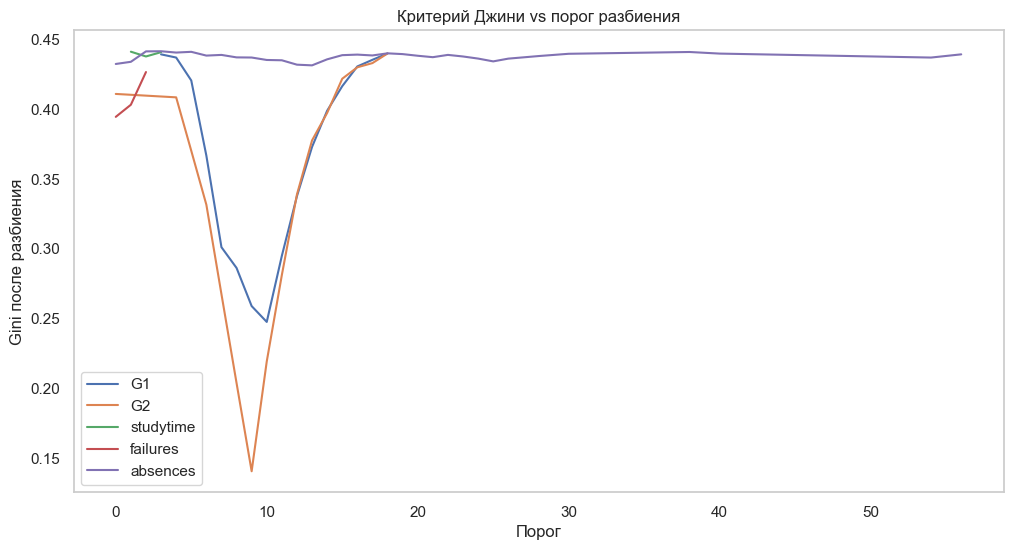

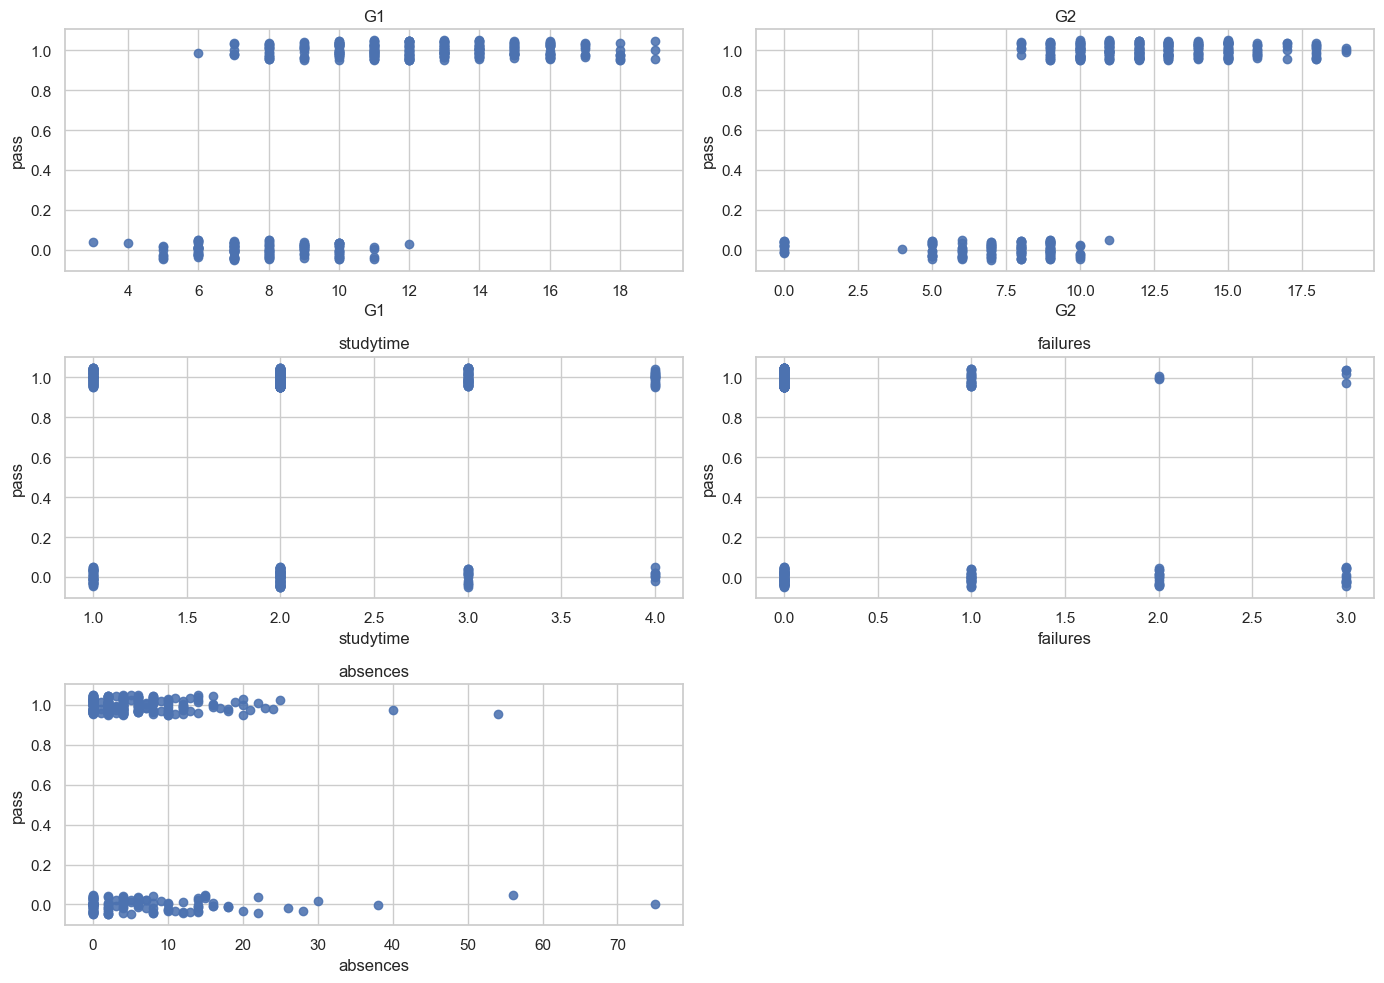

In [21]:
df = pd.read_csv("student-mat.csv", sep=";")

df["pass"] = (df["G3"] >= 10).astype(int)

y = df["pass"].values

features = ["G1", "G2", "studytime", "failures", "absences"]

def gini(y):
    _, c = np.unique(y, return_counts=True)
    p = c / len(y)
    return 1 - np.sum(p ** 2)

plt.figure(figsize=(12, 6))

for feat in features:
    x = df[feat].values

    thresholds = np.unique(x)
    gini_vals = []

    for t in thresholds:
        left = y[x <= t]
        right = y[x > t]

        if len(left) == 0 or len(right) == 0:
            continue

        g = (len(left) * gini(left) + len(right) * gini(right)) / len(y)
        gini_vals.append(g)

    plt.plot(thresholds[:len(gini_vals)], gini_vals, label=feat)

plt.title("Критерий Джини vs порог разбиения")
plt.xlabel("Порог")
plt.ylabel("Gini после разбиения")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 10))

for i, feat in enumerate(features, 1):
    plt.subplot(3, 2, i)
    x = df[feat].values

    y_jitter = y + (np.random.rand(len(y)) - 0.5) * 0.1

    plt.scatter(x, y_jitter, alpha=0.878)
    plt.title(feat)
    plt.xlabel(feat)
    plt.ylabel("pass")

plt.tight_layout()
plt.show()

**Выводы:**

**1.** Деление выборки на два поддерева следует производить по признаку G2, так как Джини кривая для него достигает минимума (= min impurity), то есть классы очень хорошо разделяются.

**2.** Реузьтат согласуется с предположениями, pass=0 и pass=1 хорошо разделяет данные для G1 и G2. Касаемо studytime, absences, failure - точки перемешиваются сильнее. Выводы частично совпадают, признак failures оказался менее полезным, чем ожидалось.   

**3.** Кривые тех признаков, по которым классы разделяются хорошо характеризуются ярковыраженным минимумом критерия Gini (для G1 и G2), а для тех, где деление почти невозможно, кривая более прямая, с меньшим разбросом значений. 

__6.__

Разберемся с кодом для класса `DecisionTree` модуля `code5.py`. Подправим `_fit_node`, а также реализуем `_predict_node`.

В данном задании:
* построение дерева осуществляется согласно базовому жадному алгоритму
* выбор лучшего разбиения будем производить по критерию Джини
* в качестве критерия останова используется следующий: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку
* ответ в листе $-$ это наиболее часто встречающийся в нём класс
* для категориальных признаков выполняется Target Encoding с последующей сортировкой

__7.__

Протестируем решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Скачаем таблицу agaricus-lepiota.data и применим к каждому столбцу LabelEncoder, чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец в рассматриваемой таблице $-$ это целевая переменная ('e' $-$ edible, 'p' $-$ poisonous).

Обучим решающее дерево на $50\%$ случайно выбранных объектов и получим предсказания для оставшейся половины. Вычислим accuracy. 

In [233]:
np.random.seed(888)

df = pd.read_csv("agaricus-lepiota.data", header=None)

y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values

le_y = LabelEncoder()
y_enc = le_y.fit_transform(y)

X_enc = np.zeros_like(X, dtype=int)
for i in range(X.shape[1]):
    le = LabelEncoder()
    X_enc[:, i] = le.fit_transform(X[:, i])

X_enc = X_enc.astype(float)

n = len(y_enc)
idx = np.random.permutation(n)
train_size = n // 2
train_idx = idx[:train_size]
test_idx = idx[train_size:]

X_train, X_test = X_enc[train_idx], X_enc[test_idx]
y_train, y_test = y_enc[train_idx], y_enc[test_idx]

feature_types = ["categorical"] * X_enc.shape[1]

tree = DecisionTree(feature_types=feature_types)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 1.0


__8.__

Реализуем в классе `DecisionTree` поддержку параметров `max_depth`, `min_samples_split` и `min_samples_leaf` по аналогии с `DecisionTreeClassifier`.

__9.__

Сравним реализованное дерево со стандартной имплементацией из `sklearn` для набора данных [nursery](https://archive.ics.uci.edu/dataset/76/nursery).

In [252]:
df = pd.read_csv("nursery.data", header=None)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

le_y = LabelEncoder()
y_enc = le_y.fit_transform(y)

X_enc = np.zeros_like(X, dtype=int)
for i in range(X.shape[1]):
    le = LabelEncoder()
    X_enc[:, i] = le.fit_transform(X[:, i])

rng = np.random.RandomState(888)
train_idx, test_idx = train_test_split(np.arange(len(y_enc)),
                                       test_size=0.3,
                                       random_state=0,
                                       stratify=y_enc)
X_train, X_test = X_enc[train_idx], X_enc[test_idx]
y_train, y_test = y_enc[train_idx], y_enc[test_idx]

tree = DecisionTree(feature_types=["categorical"] * X_enc.shape[1])
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("My Tree Accuracy:", accuracy_score(y_test, y_pred))

clf = DecisionTreeClassifier(criterion="gini", random_state=0)
clf.fit(X_train, y_train)
y_pred2 = clf.predict(X_test)
print("sklearn Tree Accuracy:", accuracy_score(y_test, y_pred2))

My Tree Accuracy: 0.9974279835390947
sklearn Tree Accuracy: 0.9925411522633745


круто

## Bias-variance decomposition 

Воспользуемся возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения.

Будем работать с датасетом `California housing` из `sklearn.datasets.fetch_california_housing`. Это задача регрессии: по признакам района (доход, возраст домов и т.п.) нужно предсказать MedHouseVal - медианная стоимость жилья.

In [168]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()
X = california["data"]
y = california["target"]

X.shape, y.shape

((20640, 8), (20640,))

Во всех заданиях этого раздела (задания 10-11) используем одни и те же данные `X, y` и три стандартные модели из sklearn:

* `LinearRegression`
* `DecisionTreeRegressor`
* `RandomForestRegressor`

Поскольку все три модели имеют единый интерфейс, то это позволяет передавать их в общие функции.

In [180]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Вычисление bias и variance 

Представить ошибку алгоритма регрессии в виде суммы трех компонент можно следующим образом:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$

$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### **Приближенное вычисление интегралов**

Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [172]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.88829518364639

#### **Оценивание $\mathbb{E}_{x, y}$**

Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### **Оценивание $\mathbb{E}_X$ с помощью бутстрапа**

Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

**Почему именно выбор с возвращением?**

В классическом бутстрапе мы считаем, что единственное, что у нас есть про распределение данных $p(x, y)$, - это эмпирическое распределение на нашей выборке: каждый объект имеет вероятность $1/N$. Тогда "новая" обучающая выборка размера $N$ моделируется как $N$ независимых выборов *с возвращением* из этого эмпирического распределения.

Отсюда появляются:
* повторы объектов в бутстрап-выборке,
* и, наоборот, out-of-bag объекты, которые в конкретную бутстрап-выборку не попали.

Повторы не являются ошибкой или "зашумлением" эксперимента - они как раз и отражают то, насколько алгоритм чувствителен к конкретным объектам (в том числе к выбросам). Если бы мы каждый раз просто брали подвыборки без возвращения, мы бы изучали уже немного другую процедуру (скорее subsampling / k-fold CV), а не классический бутстрап.

#### **Итоговый алгоритм оценки смещения и разброса алгоритма $a$**
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [тут](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__10.1__

Реализуем описанный алгоритм. Учтем, что если объект не вошел ни в одну из out-of-bag выборок, то участвовать в вычислении итоговых величин он уже не будет.

In [186]:
from tqdm import tqdm

def compute_bias_variance(model, X, y, num_runs=1000, progress=False):
    n_samples = X.shape[0]
    predictions_per_obj = [[] for _ in range(n_samples)]
    rng = np.random.RandomState(888)  

    iterator = range(num_runs)
    if progress:
        iterator = tqdm(iterator, desc="Bootstrap runs")

    for run in iterator:
        indices = rng.randint(0, n_samples, n_samples)
        oob_mask = np.ones(n_samples, dtype=bool)
        oob_mask[indices] = False 

        if not np.any(oob_mask):
            continue

        X_boot = X[indices]
        y_boot = y[indices]

        model_clone = clone(model)
        model_clone.fit(X_boot, y_boot)

        X_oob = X[oob_mask]
        y_pred_oob = model_clone.predict(X_oob)

        for idx, pred in zip(np.where(oob_mask)[0], y_pred_oob):
            predictions_per_obj[idx].append(pred)

    bias_list = []
    var_list = []
    error_list = []

    for idx, preds in enumerate(predictions_per_obj):
        if len(preds) == 0:
            continue 

        preds = np.array(preds)
        mean_pred = preds.mean()
        bias_list.append((mean_pred - y[idx])**2)
        var_list.append(preds.var())
        error_list.extend((preds - y[idx])**2)

    bias = np.mean(bias_list)
    variance = np.mean(var_list)
    error = np.mean(error_list)

    return bias, variance, error

__10.2__

Оценим смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [188]:
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor()
}

for name, model in models.items():
    if name == "RandomForest":
        bias_sq, var, err = compute_bias_variance(model, X, y, num_runs=200, progress=True)
    else:
        bias_sq, var, err = compute_bias_variance(model, X, y, num_runs=200)
        
    print(f"{name}: bias^2 = {bias_sq:.4f}, variance = {var:.4f}, error = {err:.4f}, sum = {bias_sq+var:.4f}")

LinearRegression: bias^2 = 0.5609, variance = 0.2043, error = 0.7618, sum = 0.7652
DecisionTree: bias^2 = 0.2460, variance = 0.2992, error = 0.5454, sum = 0.5452


Bootstrap runs: 100%|██████████| 200/200 [39:49<00:00, 11.95s/it]


RandomForest: bias^2 = 0.2469, variance = 0.0186, error = 0.2656, sum = 0.2655


Линейная регрессия имеет систематическую ошибку, что можно было ожидать, ведь она не улавливает сложные зависимости. У нее вследствие высокое смещение, но низкая диспресия.

Решающее дерево может улавливать более сложные зависимости в данных чем линейная регрессия, однако обучение менее стабильно. Как следствие, низкое смещение и высокая дисперсия.

Случайны лес показывает наименьшую ошибку и сильно снижает дисперсию, сохраняя смещение и усредняя предикты, по сравнению с решающим деревом.

Таким образом, результаты полностью согласуются с материалом занятий и лекций.

__10.3__
Построим бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). 

**Примечания** 

Согласно теории разброс после беггинга должен был уменьшиться в M раз, где M - количество деревьев.

В моих экспериментах уменьшение произошло примерно в M/2 раз - что абсолютно логично, ведь условие независимости алгоритмов на практике почти никогда не соблюдается. 

In [196]:
num_estimators = 50

def bagging_bias_variance(model, X, y, num_estimators):
    n_samples = X.shape[0]
    predictions_oob = [[] for _ in range(n_samples)]
    rng = np.random.default_rng(888)

    for est in tqdm(range(num_estimators), desc=f"Training {type(model).__name__} estimators"):
        idx_boot = rng.choice(n_samples, size=n_samples, replace=True)
        X_boot, y_boot = X[idx_boot], y[idx_boot]

        m = clone(model)
        m.fit(X_boot, y_boot)

        oob_idx = np.setdiff1d(np.arange(n_samples), np.unique(idx_boot))
        for i in oob_idx:
            predictions_oob[i].append(m.predict(X[i].reshape(1, -1))[0])

    bias_list = []
    var_list = []
    error_list = []

    for i, preds in enumerate(predictions_oob):
        if len(preds) == 0:
            continue
        pred_mean = np.mean(preds)
        bias_list.append((pred_mean - y[i])**2)
        var_list.append(np.var(preds))
        error_list.append(np.mean((np.array(preds) - y[i])**2))

    return np.mean(bias_list), np.mean(var_list), np.mean(error_list)

results = {}
for name, model in models.items():
    bias, var, err = bagging_bias_variance(model, X, y, num_estimators=num_estimators)
    results[name] = (bias, var, err)

for name, (b, v, e) in results.items():
    print(f"{name}: bias={b:.4f}, variance={v:.4f}, error={e:.4f}")

Training RandomForestRegressor estimators: 100%|██████████| 50/50 [40:40<00:00, 48.81s/it]


LinearRegression: bias=0.5307, variance=0.0099, error=0.5406
DecisionTree: bias=0.2568, variance=0.2855, error=0.5423
RandomForest: bias=0.2476, variance=0.0177, error=0.2654


### Визуализация предсказаний базовых алгоритмов бэггинга 



![](https://nvsyashwanth.github.io/machinelearningmaster/assets/images/bias_variance.jpg)

В этой части построим похожее изображение для трёх алгоритмов. Я буду решать задачу одномерной регрессии, поэтому итоговые мишени тоже будут одномерными.

__11.1__

Реализуем функцию `plot_predictions`, которая будет выполнять следующие шаги:

1. Выбор подмножества данных. Случайным образом выберем num_test_objects пар "объект-целевая переменная" из исходных данных X, y. Выбранные объекты образуют тестовую выборку X_test, y_test, остальные - обучающую выборку X_train, y_train.

2. Метод бутстрапа. Сгенерируем методом бутстрапа num_runs новых выборок из X_train, y_train. На каждой такой выборке обучим алгоритм и сделаем предсказания для объектов X_test.

3. Построение графика. Нарисуем scatter-график, где по оси абсцисс - номера тестовых объектов от 0 до num_test_objects - 1 (а не сами значения признаков); по оси ординат - предсказания моделей на этих объектах. В итоге должно получиться num_test_objects вертикальных столбиков из точек: для каждого тестового объекта его num_runs предсказаний.

   Для каждого тестового объекта:
   * отметим все предсказания для него одним цветом (чтобы был виден столбик);
   * истинный ответ y_test для этого объекта отметим чёрной точкой.

> *Примечание.* Р 
> Если хочется более явно увидеть bias–variance, можно дополнительно построить второй график, где по оси X - номера тестовых объектов, а по оси Y - разница `mean_pred(x_i) − y_i` (оценка bias), и, например, показать разброс предсказаний в виде вертикальных отрезков или доверительных интервалов.
>
> При больших значениях num_runs вместо (или вместе с) отдельных точек допустимо использовать boxplot/violinplot.

In [215]:
def plot_predictions(model, X, y, num_runs=111, num_test_objects=10, title=""):
    n_samples = X.shape[0]
    rng = np.random.default_rng(888)
    
    test_idx = rng.choice(n_samples, size=num_test_objects, replace=False)
    train_idx = np.setdiff1d(np.arange(n_samples), test_idx)
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    preds = np.zeros((num_test_objects, num_runs))
    
    for run in range(num_runs):
        idx_boot = rng.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
        X_boot, y_boot = X_train[idx_boot], y_train[idx_boot]
        
        m = clone(model)
        m.fit(X_boot, y_boot)
        preds[:, run] = m.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    for i in range(num_test_objects):
        plt.scatter([i]*num_runs, preds[i, :], alpha=0.66)
        plt.scatter(i, y_test[i], color='black', s=66, label="True value" if i==0 else "")
    
    plt.xlabel("Test object index")
    plt.ylabel("Predicted value")
    plt.title(title)
    plt.legend()
    plt.show()

__11.2__

Нарисуем графики для линейной регрессии, решающего дерева и случайного леса в строчку с одинаковой осью ординат. 

Для каждого графика прокомментируем, как он характеризует смещение и разброс соответствующего алгоритма.

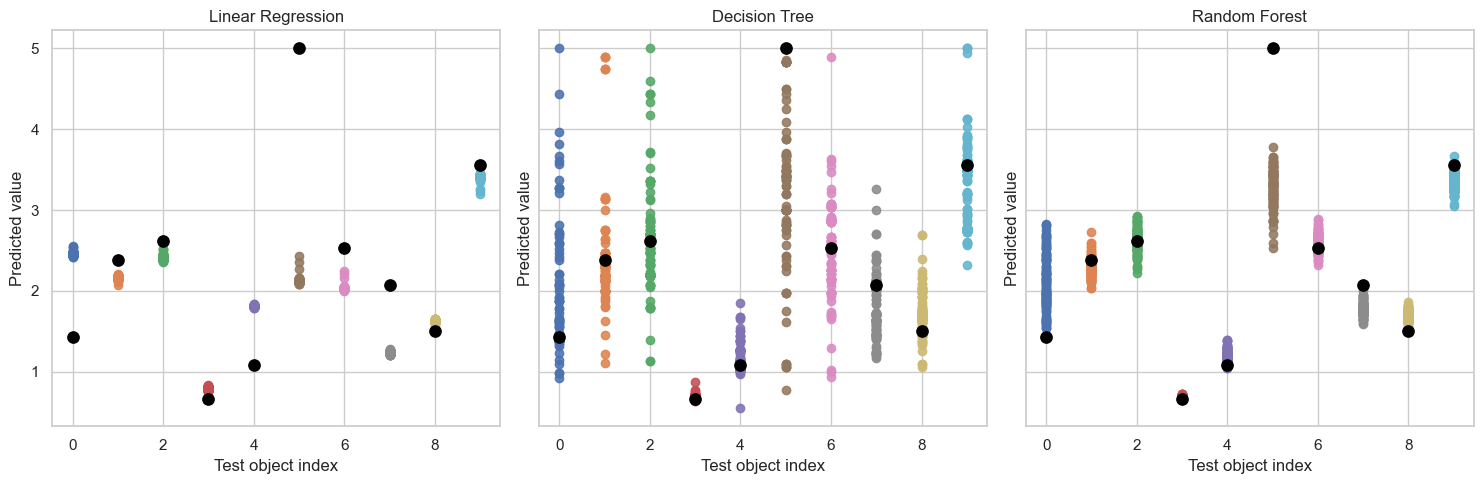

In [218]:
def plot_predictions_ax(model, X_train, y_train, X_test, y_test, ax, num_runs=111):
    n_test = X_test.shape[0]
    rng = np.random.default_rng(888)
    preds = np.zeros((n_test, num_runs))
    
    for run in range(num_runs):
        idx_boot = rng.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
        X_boot, y_boot = X_train[idx_boot], y_train[idx_boot]
        m = clone(model)
        m.fit(X_boot, y_boot)
        preds[:, run] = m.predict(X_test)
    
    for i in range(n_test):
        ax.scatter([i]*num_runs, preds[i, :], alpha=0.88)
        ax.scatter(i, y_test[i], color='black', s=66)
    
    ax.set_xlabel("Test object index")
    ax.set_ylabel("Predicted value")

num_test_objects = 10
rng = np.random.default_rng(42)
test_idx = rng.choice(X.shape[0], size=num_test_objects, replace=False)
train_idx = np.setdiff1d(np.arange(X.shape[0]), test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Random Forest", RandomForestRegressor())
]


fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for ax, (name, model) in zip(axes, models):
    plot_predictions_ax(model, X_train, y_train, X_test, y_test, ax, num_runs=111)
    ax.set_title(name)

plt.tight_layout()
plt.show()

Линейная регрессия характеризуется низким разбросом и высоким смещением. (предсказания близко к друг другу, но часто далеко от реальный значений/черных точек)

Модель решающего дерева характеризуется высоким разбросом и низким смещением. (наоброт)

Модель случайного леса характеризуется низким разбросом и довольно низким смещением. (предсказания достаточно близко к друг другу, но есть одно несовпадение с реальным значением)